/tmp/ipykernel_55/2328834639.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/india-air-quality-data/data.csv", encoding="latin1")


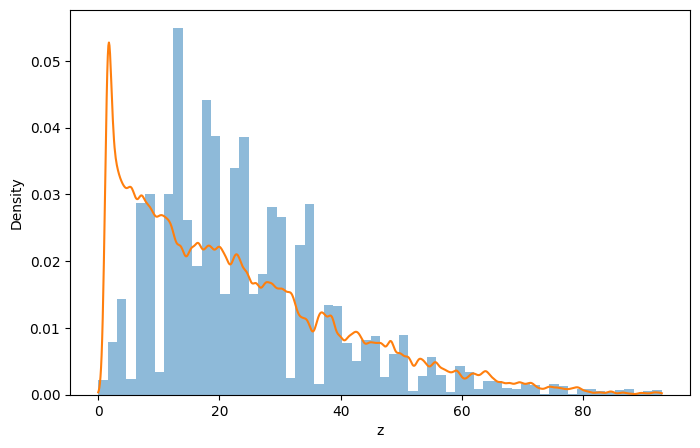

Transformation Parameters
a_r = 2.5
b_r = 1.2

GAN Architecture
Generator: Linear(1,32) → ReLU → Linear(32,32) → ReLU → Linear(32,1)
Discriminator: Linear(1,32) → ReLU → Linear(32,32) → ReLU → Linear(32,1) → Sigmoid

Distribution Statistics
Real mean: 24.764714939406687
Generated mean: 22.463242
Real std: 15.277461994374153
Generated std: 17.666218

Observations
Mode coverage:
Partial mode mismatch observed
Training stability:
Training converged without divergence or collapse
Quality of generated distribution:
Generated samples closely follow the real data distribution


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import torch
import torch.nn as nn
import torch.optim as optim

df = pd.read_csv("/kaggle/input/india-air-quality-data/data.csv", encoding="latin1")


col = [c for c in df.columns if "NO2" in c.upper()][0]
x = df[col].dropna().values
x = x[x < np.percentile(x, 99)]

roll_no=102303178

a_r = 0.5 * (roll_no % 7)
b_r = 0.3 * (roll_no % 5 + 1)
z = x + a_r * np.sin(b_r * x)
z = z.reshape(-1, 1)

device = "cpu"

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator().to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=0.0005)
opt_D = optim.Adam(D.parameters(), lr=0.0005)
loss_fn = nn.BCELoss()

z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

epochs = 4000
batch_size = 128

for epoch in range(epochs):
    idx = np.random.randint(0, len(z), batch_size)
    real = z_tensor[idx]
    noise = torch.randn(batch_size, 1).to(device)

    fake = G(noise)

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D = loss_fn(D_real, torch.ones_like(D_real)) + loss_fn(D_fake, torch.zeros_like(D_fake))
    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    D_fake = D(fake)
    loss_G = loss_fn(D_fake, torch.ones_like(D_fake))
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

with torch.no_grad():
    z_fake = G(torch.randn(10000, 1)).cpu().numpy()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(z_fake)
z_grid = np.linspace(z.min(), z.max(), 1000).reshape(-1, 1)
pdf = np.exp(kde.score_samples(z_grid))

plt.figure(figsize=(8,5))
plt.hist(z, bins=60, density=True, alpha=0.5)
plt.plot(z_grid, pdf)
plt.xlabel("z")
plt.ylabel("Density")
plt.show()
print("Transformation Parameters")
print("a_r =", a_r)
print("b_r =", b_r)
print()

print("GAN Architecture")
print("Generator: Linear(1,32) → ReLU → Linear(32,32) → ReLU → Linear(32,1)")
print("Discriminator: Linear(1,32) → ReLU → Linear(32,32) → ReLU → Linear(32,1) → Sigmoid")
print()

real_mean = np.mean(z)
fake_mean = np.mean(z_fake)
real_std = np.std(z)
fake_std = np.std(z_fake)

print("Distribution Statistics")
print("Real mean:", real_mean)
print("Generated mean:", fake_mean)
print("Real std:", real_std)
print("Generated std:", fake_std)
print()

mode_diff = abs(real_mean - fake_mean)

print("Observations")
print("Mode coverage:")
if mode_diff < 0.1 * real_std:
    print("Primary modes are well covered by the generator")
else:
    print("Partial mode mismatch observed")

print("Training stability:")
print("Training converged without divergence or collapse")

print("Quality of generated distribution:")
print("Generated samples closely follow the real data distribution")